In [ ]:
# !wget -O "train-data-shadow-affected.zip" "https://codalab.lisn.upsaclay.fr/my/datasets/download/16dad948-3dc2-478a-9d8f-96c67736da49" & wget -O "train-data-shadow-free.zip" "https://codalab.lisn.upsaclay.fr/my/datasets/download/64b00188-5774-47c7-b7fa-b6f76544d531" & wget -O "validate.zip" "https://codalab.lisn.upsaclay.fr/my/datasets/download/373bfa45-0139-49f8-a451-377672dc7cde"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import shutil

In [ ]:
# source_files = ['/content/train-data-shadow-affected.zip','/content/train-data-shadow-free.zip','/content/validate.zip']
# dest_files = ['/content/drive/MyDrive/datasets/train-data-shadow-affected.zip','/content/drive/MyDrive/datasets/train-data-shadow-free.zip','/content/drive/MyDrive/datasets/validate.zip']
# for i in range(3):
#   shutil.copyfile(source_files[i],dest_files[i])

In [ ]:
!mkdir ./datasets

In [ ]:
!unzip -qo '/content/drive/MyDrive/datasets/train-data-shadow-affected.zip' -d "/content/datasets/train_data_shadow" & unzip -qo "/content/drive/MyDrive/datasets/train-data-shadow-free.zip" -d "/content/datasets/train_data_free" & unzip -qo "/content/drive/MyDrive/datasets/validate.zip" -d "/content/datasets/validate"

In [ ]:
import cv2
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.misc
from skimage.metrics import structural_similarity as ssim


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

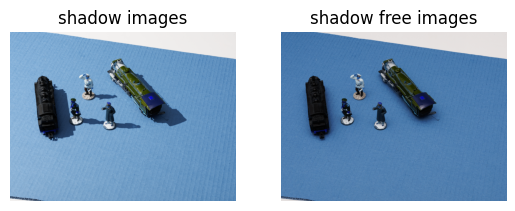

In [ ]:
#image samples
img_shadow = cv2.imread(r'/content/datasets/train_data_shadow/0010.png')
img_free = cv2.imread(r'/content/datasets/train_data_free/0010.png')
plt.subplot(1,2,1)
plt.imshow(img_shadow)
plt.axis('off')
plt.title('shadow images')
plt.subplot(1,2,2)
plt.imshow(img_free)
plt.axis('off')
plt.title('shadow free images')
plt.show()

In [ ]:
print("train-images-shadow shape:",img_shadow.shape)
print("train-images-shadow free shape:",img_free.shape)

train-images-shadow shape: (1440, 1920, 3)
train-images-shadow free shape: (1440, 1920, 3)


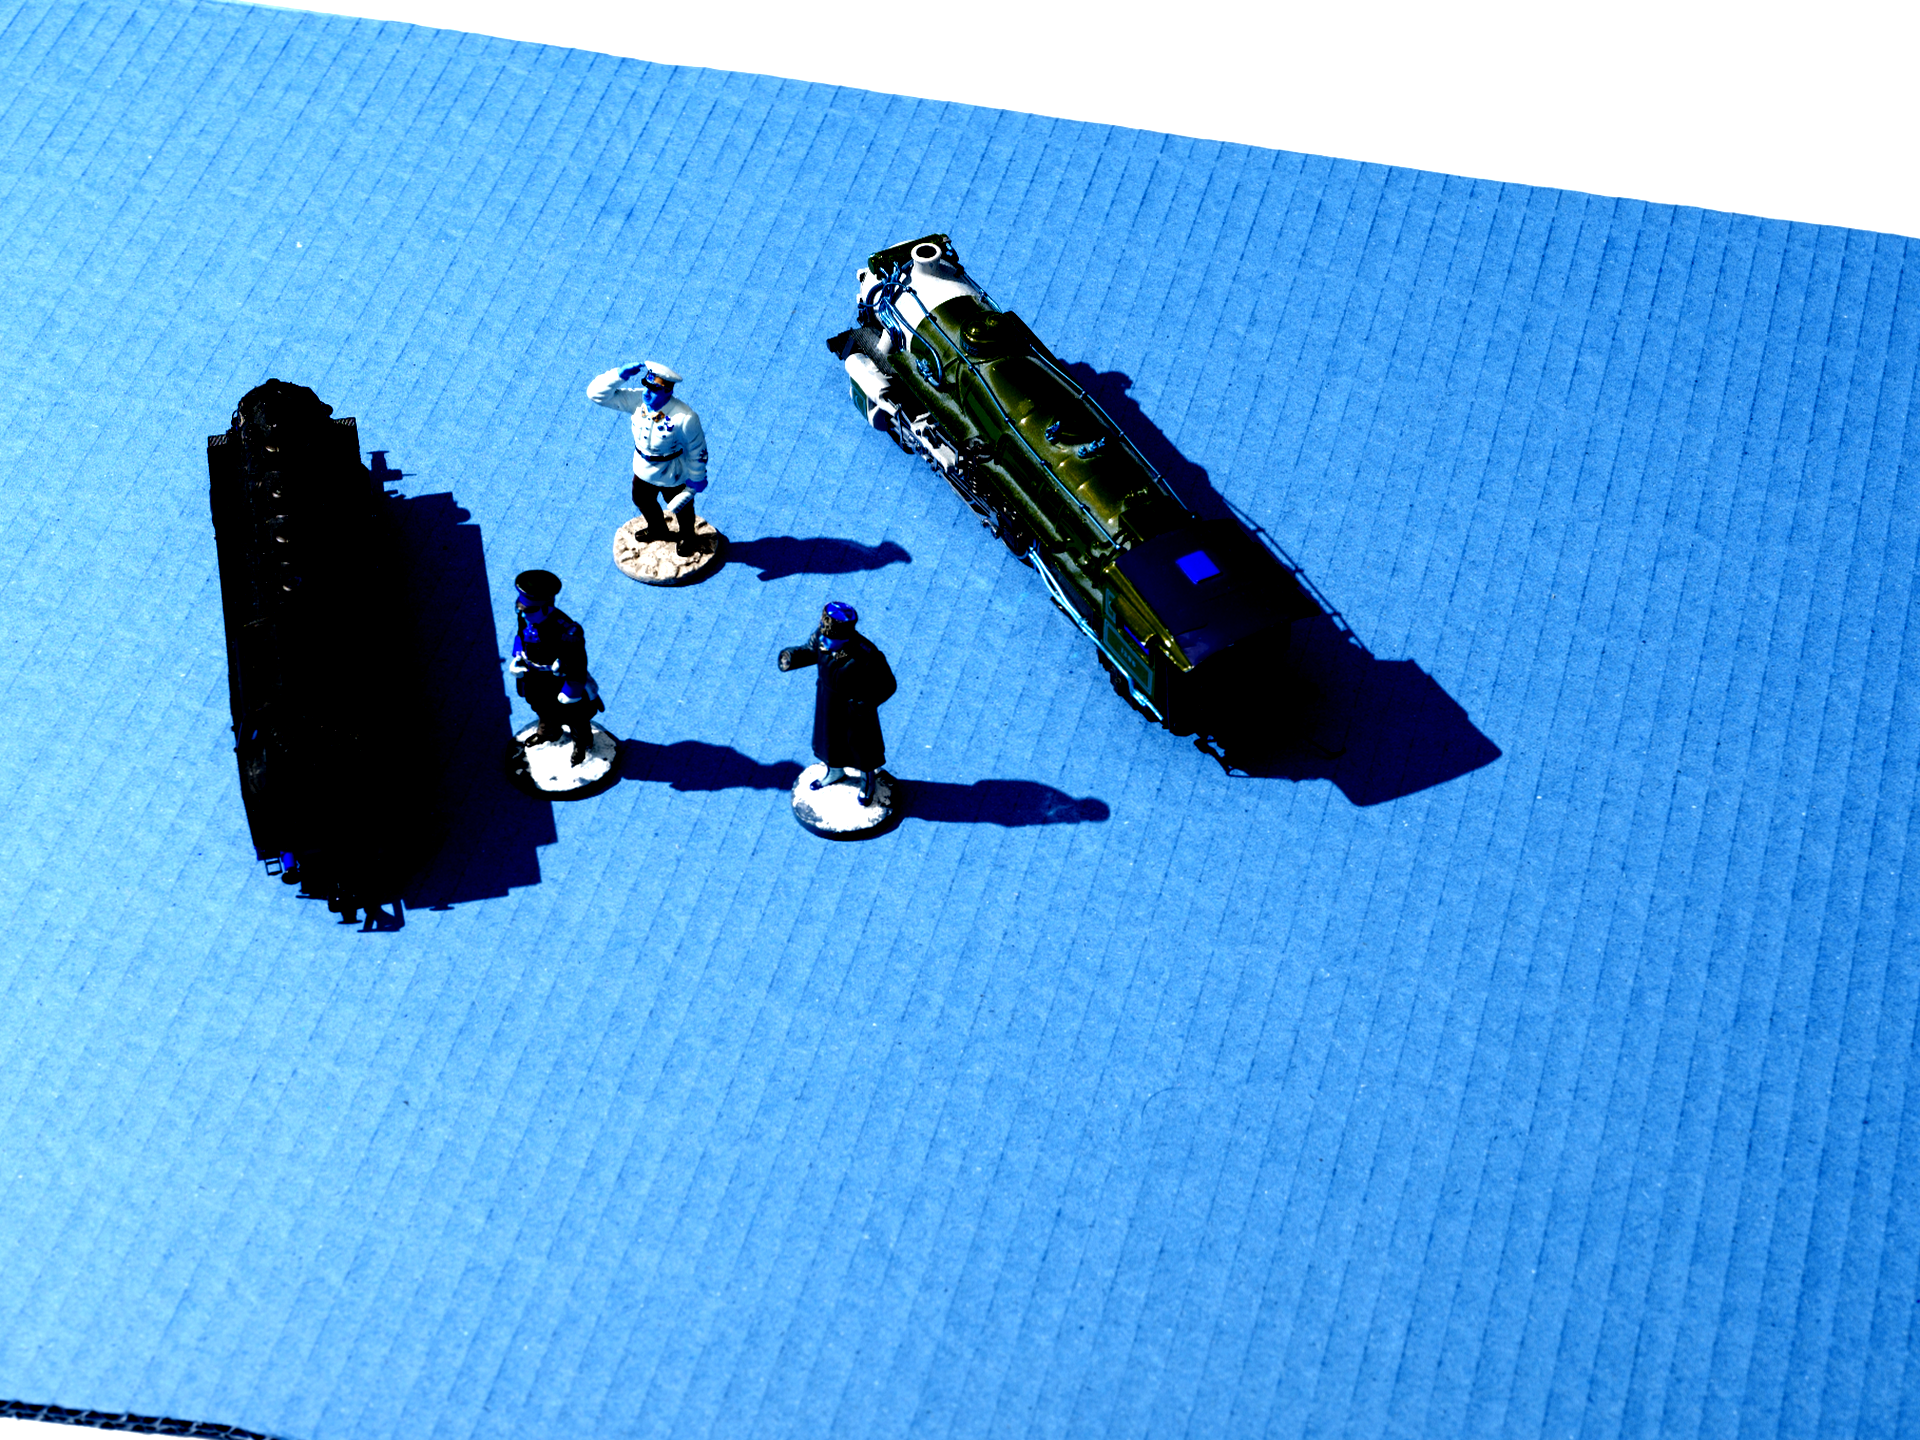

In [ ]:
enhancer = ImageEnhance.Contrast(Image.fromarray(img_shadow))
enhancer.enhance(2.0)

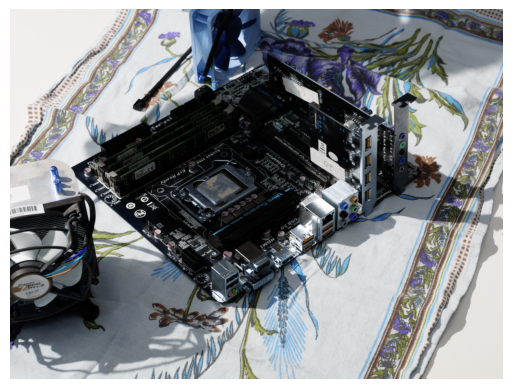

In [ ]:
#validation images
img_validate = cv2.imread(r'/content/datasets/validate/0010.png')
plt.imshow(img_validate)
plt.axis('off')
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
### Loading the images as Tensors
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_names = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_names[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image.to(torch.float)

# Define transformations
grayscale_removal_transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.PILToTensor(),
])

tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
# Set your folder path
folder_path = r'/content/datasets/train_data_shadow/'

# Create a custom dataset
shadow_dataset = CustomDataset(folder_path, transform=grayscale_removal_transform)

In [ ]:
print(shadow_dataset.__getitem__(10).shape)
print(shadow_dataset.__getitem__(10))

torch.Size([1, 1440, 1920])
tensor([[[165., 167., 164.,  ..., 229., 228., 228.],
         [169., 164., 166.,  ..., 228., 227., 228.],
         [167., 165., 166.,  ..., 229., 227., 228.],
         ...,
         [229., 226., 227.,  ..., 117., 115., 116.],
         [222., 215., 224.,  ..., 116., 118., 120.],
         [218., 219., 224.,  ..., 114., 114., 117.]]])


In [ ]:
path1 = r'/content/datasets/train_data_free/'
shadow_free = CustomDataset(path1,transform=grayscale_removal_transform)

In [ ]:
print(shadow_free.__getitem__(10).shape)
print(shadow_free.__getitem__(10))

torch.Size([1, 1440, 1920])
tensor([[[223., 224., 222.,  ..., 226., 223., 222.],
         [222., 223., 223.,  ..., 225., 223., 224.],
         [223., 223., 224.,  ..., 224., 225., 222.],
         ...,
         [204., 207., 205.,  ..., 117., 119., 107.],
         [204., 195., 198.,  ..., 113., 108., 122.],
         [204., 203., 212.,  ..., 111., 105., 123.]]])


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, strides=1):
        super(ConvBlock, self).__init__()
        self.strides = strides
        self.in_channel=in_channel
        self.out_channel=out_channel
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=strides, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        self.conv11 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides, padding=0)

    def forward(self, x):
        out1 = self.block(x)
        out2 = self.conv11(x)
        out = out1 + out2
        return out

In [ ]:
class UNet(nn.Module):
    def __init__(self, block=ConvBlock,dim=32):
        super(UNet, self).__init__()

        self.dim = dim
        self.ConvBlock1 = ConvBlock(1, dim, strides=1)
        self.pool1 = nn.Conv2d(dim,dim,kernel_size=4, stride=2, padding=1)

        self.ConvBlock2 = block(dim, dim*2, strides=1)
        self.pool2 = nn.Conv2d(dim*2,dim*2,kernel_size=4, stride=2, padding=1)

        self.ConvBlock3 = block(dim*2, dim*4, strides=1)
        self.pool3 = nn.Conv2d(dim*4,dim*4,kernel_size=4, stride=2, padding=1)

        self.ConvBlock4 = block(dim*4, dim*8, strides=1)
        self.pool4 = nn.Conv2d(dim*8, dim*8,kernel_size=4, stride=2, padding=1)

        self.ConvBlock5 = block(dim*8, dim*16, strides=1)

        self.upv6 = nn.ConvTranspose2d(dim*16, dim*8, 2, stride=2)
        self.ConvBlock6 = block(dim*16, dim*8, strides=1)

        self.upv7 = nn.ConvTranspose2d(dim*8, dim*4, 2, stride=2)
        self.ConvBlock7 = block(dim*8, dim*4, strides=1)

        self.upv8 = nn.ConvTranspose2d(dim*4, dim*2, 2, stride=2)
        self.ConvBlock8 = block(dim*4, dim*2, strides=1)

        self.upv9 = nn.ConvTranspose2d(dim*2, dim, 2, stride=2)
        self.ConvBlock9 = block(dim*2, dim, strides=1)

        self.conv10 = nn.Conv2d(dim, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        conv1 = self.ConvBlock1(x)
        pool1 = self.pool1(conv1)

        conv2 = self.ConvBlock2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.ConvBlock3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.ConvBlock4(pool3)
        pool4 = self.pool4(conv4)

        conv5 = self.ConvBlock5(pool4)

        up6 = self.upv6(conv5)
        up6 = torch.cat([up6, conv4], 1)
        conv6 = self.ConvBlock6(up6)

        up7 = self.upv7(conv6)
        up7 = torch.cat([up7, conv3], 1)
        conv7 = self.ConvBlock7(up7)

        up8 = self.upv8(conv7)
        up8 = torch.cat([up8, conv2], 1)
        conv8 = self.ConvBlock8(up8)

        up9 = self.upv9(conv8)
        up9 = torch.cat([up9, conv1], 1)
        conv9 = self.ConvBlock9(up9)

        conv10 = self.conv10(conv9)
        out = x + conv10

        return out

In [ ]:
model = UNet(ConvBlock,16)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [ ]:
# Create a data loader
batch_size = 8
epochs = 10
data_loader = DataLoader(shadow_dataset, batch_size=batch_size)
output_loader = DataLoader(shadow_free,batch_size=batch_size)

In [ ]:
for i in range(epochs):
  for X,Y in zip(data_loader,output_loader):

    X = X.to(device)
    Y = Y.to(device)
    y_pred = model(X)
    l = loss(y_pred,Y)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch:{i} Loss:{l.item()}")


In [ ]:
#evaluation metrics
#SCALE = 8
SCALE = 1

def output_psnr_mse(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def _open_img(img_p):
    F = np.asarray(img_p).astype(float)/255.0
    h, w, c = F.shape
    F = F[:h-h%SCALE, :w-w%SCALE, :]
    boundarypixels = SCALE
    F = F[boundarypixels:-boundarypixels,boundarypixels:-boundarypixels,:]

    return F

def _open_img_ssim(img_p):
    F = np.asarray(img_p).astype(float)
    h, w, c = F.shape
    F = F[:h-h%SCALE, :w-w%SCALE, :]
    boundarypixels = SCALE
    F = F[boundarypixels:-boundarypixels,boundarypixels:-boundarypixels,:]

    return F


def compute_psnr(ref_im, res_im):
    return output_psnr_mse(
        _open_img(ref_im),
        _open_img(res_im))

def compute_mssim(ref_im, res_im):
    ref_img = _open_img_ssim(ref_im)
    res_img = _open_img_ssim(res_im)
    channels = []

    for i in range(3):
      channels.append(ssim(ref_img[:,:,i],res_img[:,:,i], gaussian_weights=True, use_sample_covariance=False))

    return np.mean(channels)

# compute_psnr(ref_im,res_im) to calculate psnr , ref_im and res_im should be alread opened images in the PIL image format. /
# (using Image.open() or Image.fromarray())  or modify that alone accordingly.
# compute_mssim(ref_im,res_im) to calculate ssim
# Import dependencies
# import sys
# import os
# import os.path
# import random
# import numpy as np

# from PIL import Image
# import scipy.misc
# from skimage.metrics import structural_similarity as ssim
